# IMD Radar Data - Radarx
- Author Hamid

In [1]:
import os
import glob
import radarx as rx
import xradar as xd
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
files = glob.glob("PDP200519IMD-C/*")

In [3]:
dtree = rx.io.read_volume(files)

INFO:radarx.io.imd:Successfully grouped files into 25 sweep groups.


In [4]:
dtree.groups

('/',
 '/volume_0',
 '/volume_1',
 '/volume_2',
 '/volume_3',
 '/volume_4',
 '/volume_5',
 '/volume_6',
 '/volume_7',
 '/volume_8',
 '/volume_9',
 '/volume_10',
 '/volume_11',
 '/volume_12',
 '/volume_13',
 '/volume_14',
 '/volume_15',
 '/volume_16',
 '/volume_17',
 '/volume_18',
 '/volume_19',
 '/volume_20',
 '/volume_21',
 '/volume_22',
 '/volume_23',
 '/volume_24')

In [5]:
# We can save all these cfradial1 files by iterating over the dtree object

outdir = "IMD_OUT"
os.makedirs(outdir, exist_ok=True)
for key in dtree.children:
    ds = dtree[key].ds
    time_str = ds.time.min().dt.strftime("%Y%m%d_%H%M%S").item()
    ds.to_netcdf(os.path.join(outdir, f"PDP_{time_str}_cfrad1.nc"))

In [6]:
ls IMD_OUT

PDP_20200519_004025_cfrad1.nc  PDP_20200519_105026_cfrad1.nc
PDP_20200519_014025_cfrad1.nc  PDP_20200519_125136_cfrad1.nc
PDP_20200519_015025_cfrad1.nc  PDP_20200519_130026_cfrad1.nc
PDP_20200519_020026_cfrad1.nc  PDP_20200519_165026_cfrad1.nc
PDP_20200519_021025_cfrad1.nc  PDP_20200519_173026_cfrad1.nc
PDP_20200519_025025_cfrad1.nc  PDP_20200519_184026_cfrad1.nc
PDP_20200519_032025_cfrad1.nc  PDP_20200519_192026_cfrad1.nc
PDP_20200519_035025_cfrad1.nc  PDP_20200519_200026_cfrad1.nc
PDP_20200519_043026_cfrad1.nc  PDP_20200519_202025_cfrad1.nc
PDP_20200519_060025_cfrad1.nc  PDP_20200519_221026_cfrad1.nc
PDP_20200519_073026_cfrad1.nc  PDP_20200519_223026_cfrad1.nc
PDP_20200519_081025_cfrad1.nc  PDP_20200519_233025_cfrad1.nc
PDP_20200519_083026_cfrad1.nc


In [7]:
cf_dtree = rx.io.to_cfradial2_volumes(dtree)

In [8]:
cf_dtree['volume_0']['sweep_0'].ds

<xarray.DatasetView> Size: 3MB
Dimensions:            (azimuth: 360, range: 500)
Coordinates:
  * azimuth            (azimuth) float32 1kB 0.8679 1.84 2.878 ... 358.9 359.9
    elevation          (azimuth) float32 1kB 0.1868 0.1868 ... 0.2087 0.1978
    time               (azimuth) datetime64[ns] 3kB 2020-05-19T00:40:25 ... 2...
  * range              (range) float64 4kB 1e+03 2e+03 3e+03 ... 4.99e+05 5e+05
    latitude           float32 4B ...
    longitude          float32 4B ...
    altitude           float32 4B ...
Data variables:
    altitude_agl       (azimuth) float32 1kB 10.0 10.0 10.0 ... 10.0 10.0 10.0
    beamWidthVert      (azimuth) float32 1kB 0.93 0.93 0.93 ... 0.93 0.93 0.93
    DBT                (azimuth, range) float32 720kB 17.5 19.5 51.5 ... nan nan
    DBZ                (azimuth, range) float32 720kB 0.0 nan nan ... nan nan
    VEL                (azimuth, range) float32 720kB nan nan nan ... nan nan
    WIDTH              (azimuth, range) float32 720kB nan nan nan ... nan nan
    ray_gate_spacing   (azimuth) float32 1kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
    sweep_fixed_angle  float32 4B 0.1978
    sweep_mode         <U20 80B 'azimuth_surveillance'
    sweep_number       int64 8B 0

In [9]:
def filter_radar(ds):
    ds = ds.where((ds.DBZ >= 0) & (ds.DBZ <= 70))
    return ds

In [10]:
for vol in cf_dtree.match("volume_*"):
    cf_dtree[vol] = cf_dtree[vol].xradar.georeference()
    for swp in cf_dtree[vol].match("sweep_*"):
        cf_dtree[vol][swp] = cf_dtree[vol][swp].xradar.map_over_sweeps(filter_radar)

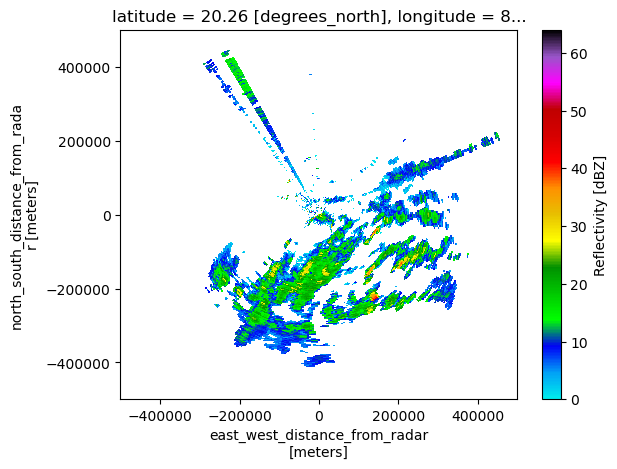

In [11]:
cf_dtree['volume_0']['sweep_0']['DBZ'].plot(x='x', y='y', cmap='NWSRef')

## Important note
You can save this CFRADIAL2 data using xarray and then read it using xradar

In [12]:
# cf_dtree.to_netcdf("EXAMPLE_NAME_CFRAD2.nc")
# ## and you can read it using xarray
# dtree_cf = xr.open_datatree("EXAMPLE_NAME_CFRAD2.nc")
# dtree_cf

## Gridding

### Setup grid resolution here

In this setup:
- The horizontal domain extends from -200 km to 200 km in both x and y directions.
- The vertical domain extends from 0 km to 10 km in altitude.
- The grid resolution is set to 2000 m (2 km) horizontally and 1000 m (1 km) vertically.
- If finer resolution is required, consider using 500 m for horizontal and 100 m for vertical resolution for higher detail.

In [13]:
x_lims = (-200e3, 200e3)
y_lims = (-200e3, 200e3)
z_lims = (0, 10e3)
h_res = 2000
v_res = 1000

In [14]:
tstart = datetime.now()

datasets = []
for vol in cf_dtree.match("volume_*"):
    ds_rx = cf_dtree[vol].radarx.to_grid(
        data_vars=["DBZ"],
        pseudo_cappi=False,
        x_lim=x_lims,
        y_lim=y_lims,
        z_lim=z_lims,
        x_step=h_res,
        y_step=h_res,
        z_step=v_res,
        x_smth=0.2,
        y_smth=0.2,
        z_smth=0.6,
    )
    datasets.append(ds_rx)
    print("Radarx gridding took:", datetime.now() - tstart)

ds = xr.concat(datasets, dim='time')
display(ds)

Radarx gridding took: 0:00:03.271382
Radarx gridding took: 0:00:03.518623
Radarx gridding took: 0:00:03.760848
Radarx gridding took: 0:00:03.999532
Radarx gridding took: 0:00:04.243314
Radarx gridding took: 0:00:04.491200
Radarx gridding took: 0:00:04.736168
Radarx gridding took: 0:00:04.979038
Radarx gridding took: 0:00:05.220974
Radarx gridding took: 0:00:05.466579
Radarx gridding took: 0:00:05.708527
Radarx gridding took: 0:00:05.951062
Radarx gridding took: 0:00:06.188089
Radarx gridding took: 0:00:06.429165
Radarx gridding took: 0:00:06.680941
Radarx gridding took: 0:00:06.923714
Radarx gridding took: 0:00:07.159351
Radarx gridding took: 0:00:07.394301
Radarx gridding took: 0:00:07.650493
Radarx gridding took: 0:00:07.894974
Radarx gridding took: 0:00:08.134714
Radarx gridding took: 0:00:08.368657
Radarx gridding took: 0:00:08.601904
Radarx gridding took: 0:00:08.844669
Radarx gridding took: 0:00:09.091545


/Users/syed44/micromamba/envs/radar-env/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.Dataset> Size: 44MB
Dimensions:    (time: 25, z: 11, y: 201, x: 201)
Coordinates:
  * time       (time) datetime64[ns] 200B 2020-05-19T00:41:11.649074076 ... 2...
  * z          (z) float64 88B 0.0 1e+03 2e+03 3e+03 ... 7e+03 8e+03 9e+03 1e+04
    lat        (y) float64 2kB 18.44 18.46 18.48 18.5 ... 22.0 22.02 22.04 22.05
    lon        (x) float64 2kB 84.76 84.78 84.8 84.82 ... 88.55 88.57 88.59
    latitude   float32 4B 20.26
    longitude  float32 4B 86.65
    altitude   float32 4B 44.0
    crs_wkt    int64 8B 0
  * x          (x) float64 2kB -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
  * y          (y) float64 2kB -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
Data variables:
    DBZ        (time, z, y, x) float32 44MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:      CF/Radial instrument_parameters
    version:          1.3
    title:            
    institution:      India Meteorological Department
    references:       
    source:           
    comment:          im/radarx
    instrument_name:  
    history:          
    radar_name:

In [20]:
## To save the gridded dataset
# ds.to_netcdf("filename_gridded_datetime_radar.nc")

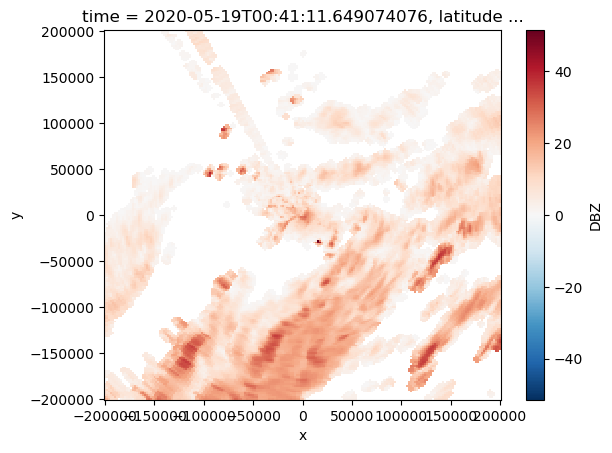

In [15]:
ds['DBZ'].isel(time=0).max("z").plot()

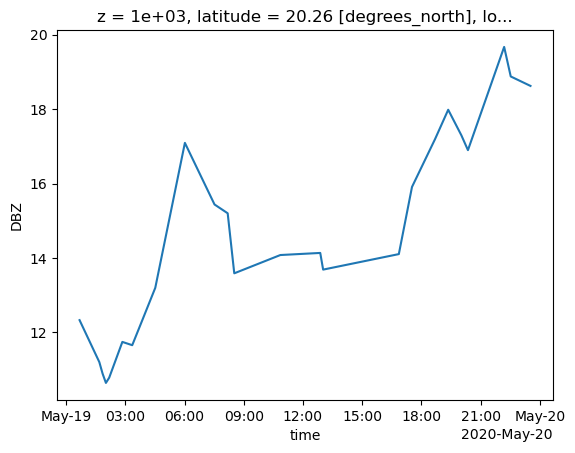

In [16]:
ds['DBZ'].isel(z=1).sel(x=slice(-150e3, 100e3), y=slice(-200e3, -50e3)).mean(['x', 'y']).plot()

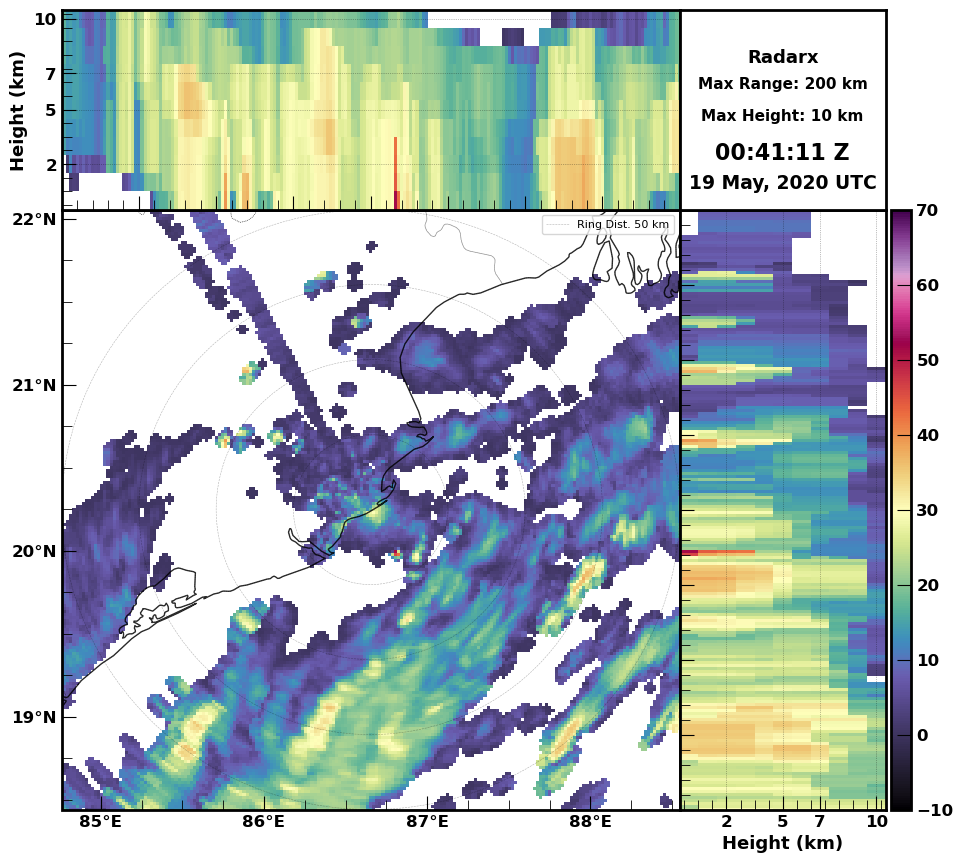

In [18]:
ds.isel(time=0).radarx.plot_max_cappi(
    data_var="DBZ",
    vmin=-10,
    vmax=70,
    range_rings=True,
    add_map=True,
    projection=ccrs.PlateCarree(),
    title="Radarx",
)
plt.show()

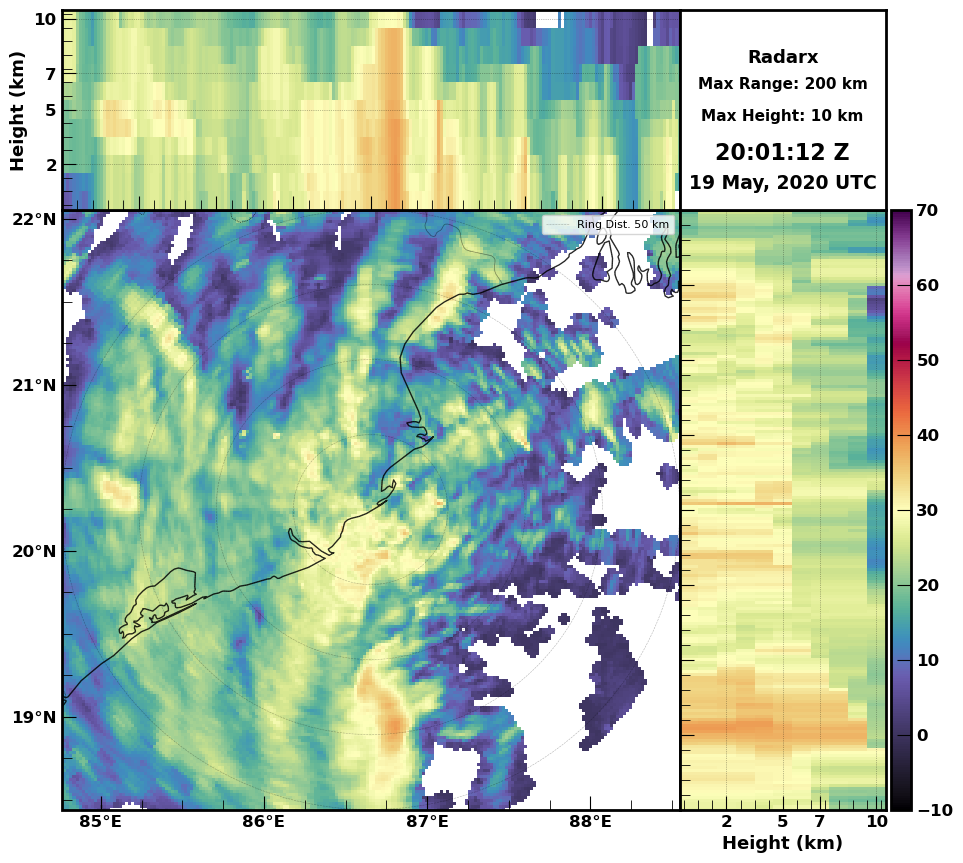

In [19]:
ds.isel(time=20).radarx.plot_max_cappi(
    data_var="DBZ",
    vmin=-10,
    vmax=70,
    range_rings=True,
    add_map=True,
    projection=ccrs.PlateCarree(),
    title="Radarx",
)
plt.show()